In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.20.0


In [2]:
# Path ke dataset yang sudah kita perbaiki
dataset_path = '../data/plantvillage/'

# Ukuran gambar yang akan kita gunakan untuk model
# MobileNetV2 dilatih dengan gambar 224x224
IMG_WIDTH, IMG_HEIGHT = 224, 224

# Ukuran batch (berapa banyak gambar yang diproses sekali jalan)
BATCH_SIZE = 32

In [3]:
# Membuat generator untuk data training dan validasi
# Kita akan membagi data kita: 80% untuk training, 20% untuk validasi
datagen = ImageDataGenerator(
    rescale=1./255,                 # Normalisasi nilai piksel dari [0, 255] ke [0, 1]
    validation_split=0.2,           # Memisahkan 20% data untuk validasi
    
    # --- Data Augmentation ---
    # Ini hanya diterapkan pada data training untuk membuat model lebih tangguh
    rotation_range=30,              # Rotasi gambar secara acak hingga 30 derajat
    width_shift_range=0.2,          # Geser gambar secara horizontal
    height_shift_range=0.2,         # Geser gambar secara vertikal
    shear_range=0.2,                # Miringkan gambar
    zoom_range=0.2,                 # Zoom gambar secara acak
    horizontal_flip=True,           # Balik gambar secara horizontal
    fill_mode='nearest'             # Cara mengisi piksel yang hilang setelah transformasi
)

# Membuat 'aliran' data dari direktori untuk training
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',       # Karena kita punya >2 kelas
    subset='training'               # Tandai ini sebagai set training
)

# Membuat 'aliran' data dari direktori untuk validasi
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'             # Tandai ini sebagai set validasi
)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [4]:
# Dapatkan jumlah kelas dari generator
num_classes = train_generator.num_classes
print(f"Jumlah kelas yang terdeteksi: {num_classes}")

# 1. Muat base model MobileNetV2 (tanpa lapisan klasifikasi teratas)
base_model = MobileNetV2(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    include_top=False,  # Penting! Kita akan membuat lapisan 'top' kita sendiri
    weights='imagenet'  # Gunakan bobot yang sudah dilatih di ImageNet
)

# 2. Bekukan bobot dari base model agar tidak ikut terlatih di awal
base_model.trainable = False

# 3. Buat lapisan 'kepala' (head) kustom kita
#    Kita akan menumpuk lapisan-lapisan ini di atas base_model
inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
x = base_model(inputs, training=False) # Pastikan base model berjalan dalam mode inference
x = GlobalAveragePooling2D()(x)       # Meratakan output fitur menjadi vektor
x = Dropout(0.5)(x)                   # Lapisan Dropout untuk mengurangi overfitting
x = Dense(1024, activation='relu')(x)   # Lapisan Dense tersembunyi
outputs = Dense(num_classes, activation='softmax')(x) # Lapisan output dengan aktivasi softmax

# 4. Gabungkan menjadi model akhir
model = Model(inputs, outputs)

# 5. Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan arsitektur model
model.summary()

Jumlah kelas yang terdeteksi: 15
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │          15,375 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,585,103 (13.68 MB)

 Trainable params: 1,327,119 (5.06 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
# Tentukan berapa banyak 'epoch' yang kita inginkan
# Satu epoch berarti model telah melihat semua data training satu kali.
EPOCHS = 10

# Mulai proses training
# Kita simpan hasilnya ke dalam variabel 'history' untuk dianalisis nanti
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1 # Tampilkan progress bar
)

Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 798s 2s/step - accuracy: 0.7004 - loss: 0.9302 - val_accuracy: 0.8365 - val_loss: 0.5069
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 288s 536ms/step - accuracy: 0.7725 - loss: 0.6725 - val_accuracy: 0.8389 - val_loss: 0.4578
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 205s 396ms/step - accuracy: 0.7959 - loss: 0.5995 - val_accuracy: 0.8506 - val_loss: 0.4505
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 212s 411ms/step - accuracy: 0.8084 - loss: 0.5600 - val_accuracy: 0.8627 - val_loss: 0.4036
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 223s 431ms/step - accuracy: 0.8152 - loss: 0.5487 - val_accuracy: 0.8673 - val_loss: 0.3945
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 277s 536ms/step - accuracy: 0.8217 - loss: 0.5141 - val_accuracy: 0.8785 - val_loss: 0.3543
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 700s 1s/step - accuracy: 0.8296 - loss: 0.4964 - val_accuracy: 0.8486 - val_loss: 0.4291
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 583s 1s/step - accuracy: 0.8347 - loss: 0.

In [8]:
# Buat folder untuk menyimpan model jika belum ada
if not os.path.exists('../models'):
    os.makedirs('../models')

# Simpan model ke dalam file .h5
model.save('../models/plant_disease_model.h5')
print("Model berhasil disimpan di folder 'models'")

Model berhasil disimpan di folder 'models'


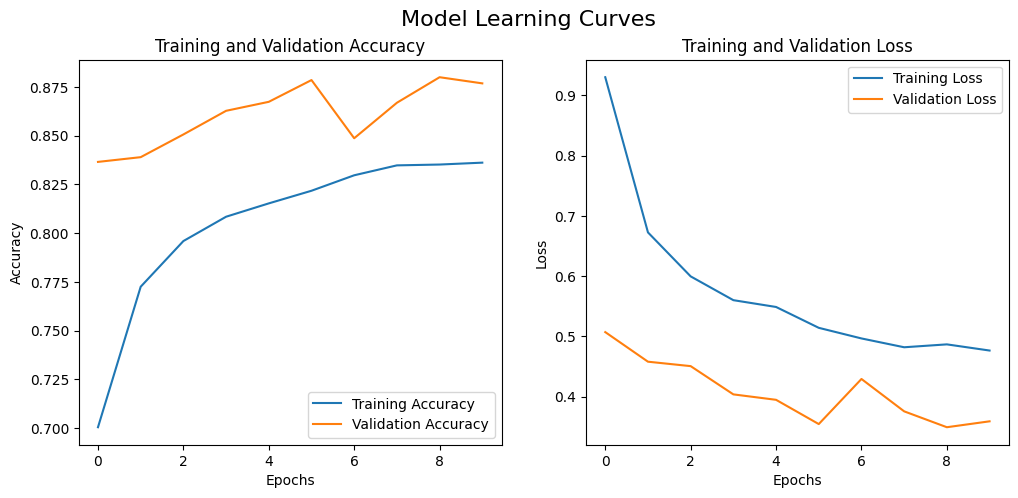

In [9]:
# Ambil data dari history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

# Buat plot
plt.figure(figsize=(12, 5))

# Plot untuk Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot untuk Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Tampilkan plot
plt.suptitle('Model Learning Curves', fontsize=16)
plt.show()